In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob 
import segmenteverygrain as seg
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Create patches from large images

In [56]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles_tuning/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles_tuning/labels/'
dirname = '/Users/zoltan/Dropbox/Segmentation/images_tuning/'
images = sorted(glob(dirname + "*image*"))
labels = sorted(glob(dirname + "*mask*"))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = image_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]
    
start_no = 0
for image in tqdm(labels):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = large_image[:,:,0,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname = mask_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]

100%|█████████████████████████████████████████████| 2/2 [01:37<00:00, 48.95s/it]


## Create training, validation, and test sets

In [2]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

batch_size = 32
shuffle_buffer_size = 1000

# First, split the data into training + validation and test sets
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    image_files,
    mask_files,
    test_size=0.15,  # 15% of the data for testing
    random_state=42  
)
# Then split the training + validation set into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images,
    train_val_masks,
    test_size=0.25,  # 25% of the remaining data for validation
    random_state=42  
)

# use this if you do not want to do image augmentation:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
# use this if you want to do image augmentation:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks, tf.Variable([True] * len(train_images), dtype=tf.bool)))
train_dataset = train_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

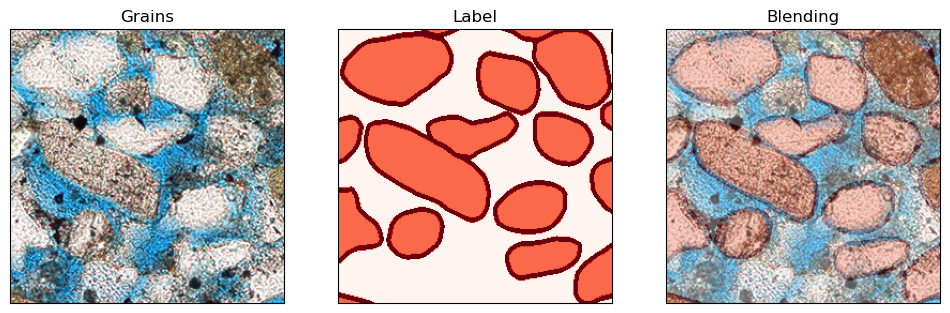

In [3]:
# check how masks look like
fname = train_images[1400]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # need to convert from BGR to RGB
mask = cv2.imread(fname.replace('images', 'labels'))
seg.plot_images_and_labels(img, mask)

## Build, train, and evaluate model

In [4]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 2,161,683 (8.25 MB)

 Trainable params: 2,160,211 (8.24 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [15]:
model.load_weights('./checkpoints/seg_model');

In [16]:
test_input = tf.random.normal((16, 256, 256, 3))
test_output = model(test_input)
print(f"Model output shape: {test_output.shape}")

Model output shape: (16, 256, 256, 3)


In [ ]:
history = model.fit(train_dataset, epochs=300, validation_data=val_dataset)

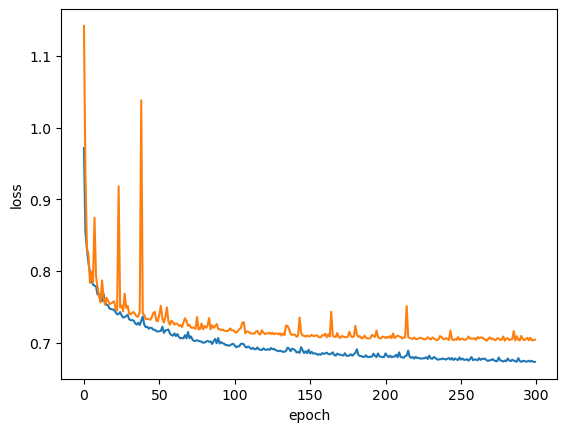

In [44]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss');

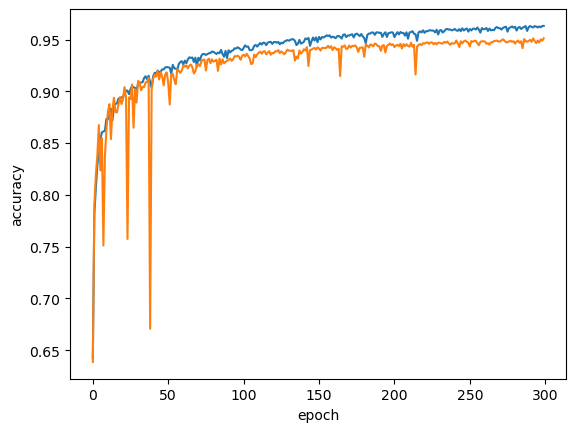

In [45]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy');

In [46]:
model.evaluate(test_dataset)

59/59 [==============================] - 4s 61ms/step - loss: 0.6996 - accuracy: 0.9523


[0.699620246887207, 0.9523232579231262]

In [63]:
model.save_weights('./checkpoints/seg_model')